# Answering Business Questions using SQL

This notebook contains solution to the guided project from dataquest. The aim of the project is to practice the intermediate SQL knowledge by answering real life business questions.

We will use the Chinook database that was used throughout the missions in dataquest Intermediate SQL course. The Chinook database is provided as a SQLite database file called chinook.db. A copy of the database schema is below. The schema of the database is provided below for ease of use.

**Database Schema**

<img src='chinook-schema.svg' width=70%>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

We will create couple of functions to help us with common tasks. Specifically:

* `run_query()` that takes a SQL query as an argument and returns a pandas dataframe of that query.
* `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module
* `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.
* `show_tables()` function.

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)
        
def show_tables():
    q = """
        SELECT name, type
        FROM sqlite_master
        WHERE type IN ("table","view");
    """
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Album Sales Analysis

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce.


| **Artist Name**  | **Genre** |
|------------------|-----------|
|     Regal        |  Hip-Hop  |
|    Red Tone      |   Punk    |
|Meteor & The Girls| Pop       |
|Slim Jim Bites    | Blues     |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

Our immediate goal is to

* Find which genres sell the most tracks in the USA
* Create a visualization of that data
* Make a suggestion for the store as to which artist albums to purchase

In [4]:
query = """
    SELECT 
        g.name genre, COUNT(il.track_id) tracks_sold,
        ROUND(100 * (CAST(COUNT(il.track_id) AS FLOAT) / 
                (SELECT COUNT(track_id) FROM invoice_line)),2) percentage
    FROM genre g
    INNER JOIN track t ON t.genre_id = g.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    GROUP BY genre
    ORDER BY tracks_sold DESC
"""

In [5]:
genre_sales_usa = run_query(query)
genre_sales_usa.head(10)

,genre,tracks_sold,percentage
0,Rock,2635,55.39
1,Metal,619,13.01
2,Alternative & Punk,492,10.34
3,Latin,167,3.51
4,R&B/Soul,159,3.34
5,Blues,124,2.61
6,Jazz,121,2.54
7,Alternative,117,2.46
8,Easy Listening,74,1.56
9,Pop,63,1.32


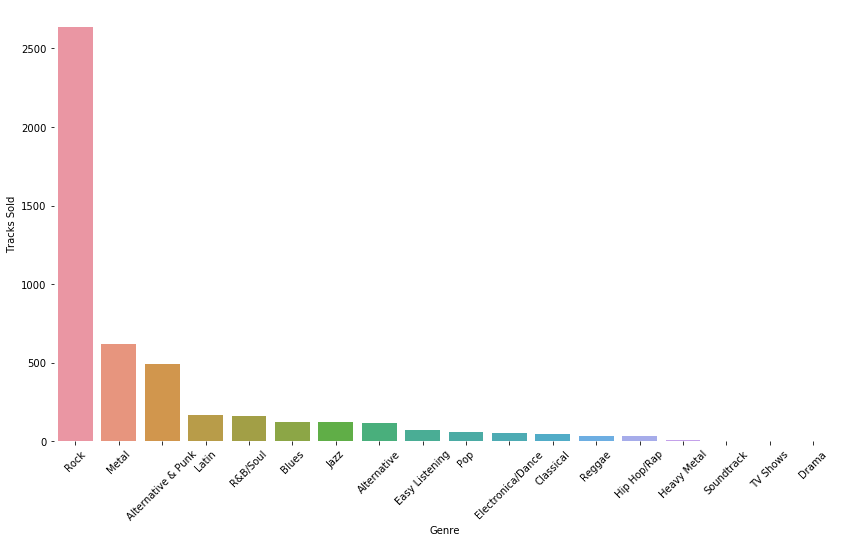

In [6]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.barplot(x = 'genre', y = 'tracks_sold', data = genre_sales_usa)
ax.set_xticklabels(genre_sales_usa['genre'], rotation=45)
ax.set_ylabel("Tracks Sold")
ax.set_xlabel("Genre")
sns.despine(left=True, bottom=True)

From the results above, we can observe that the top 5 most sold genres are:

* Rock
* Metal
* Alternative & Punk
* Latin
* R&B / Soul

Based on this it would make more sense to purchase the albums of the following artists:

* Red Tone
* Slim Jim Bites (Maybe)

Red Tone is definitely the best decision at this point since Punk is number 3 in terms of purchases. Also maybe Slim Jim Bites since Blues has sold around 124 albums.

## Sales Support Agent Performance Analysis

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Our steps are:

* Write query to find total $ amount of sales assigned to each sales support agent
* Visualize our results
* Interpret our results

In [7]:
query = """
    SELECT
        e.first_name || " " || e.last_name as agent_name,
        CAST(strftime('%Y', 'now') - strftime('%Y', e.birthdate) AS INT) age,
        CAST(strftime('%Y%m', 'now') - strftime('%Y%m', e.hire_date) AS INT) months_employed,
        SUM(i.total) tot_inv_amount
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    WHERE e.title = 'Sales Support Agent'
    GROUP BY agent_name
"""

In [8]:
emp_performance = run_query(query)
emp_performance.head(10)

,agent_name,age,months_employed,tot_inv_amount
0,Jane Peacock,46,203,1731.51
1,Margaret Park,72,202,1584.00
2,Steve Johnson,54,197,1393.92


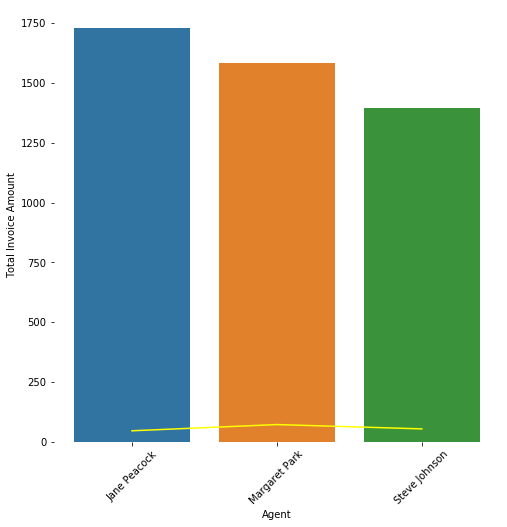

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='agent_name', y='tot_inv_amount', data=emp_performance)
sns.lineplot(x='agent_name', y='age', data=emp_performance, color='yellow')
ax.set_xticklabels(emp_performance['agent_name'], rotation=45)
ax.set_ylabel("Total Invoice Amount")
ax.set_xlabel("Agent")
sns.despine(left=True, bottom=True)

We can observe that the largest amount of sales is done by Jane and if we look at her age she is the yongest, which might be indicative of her success. We would nee further analysis and exploration to understand the effect of other features on the success of a sales agent.

## Customer Data Analysis

Out next task is to analyze the sales data for customers from each different country. We can use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer *(total value of sales / total number customers)*
* average order value *(total value of sales / total number of invoice (sum(invoice_id)))*

Our goal is to support the marketing team and advice them with countries that have potential for growth.

Next we will write our query.

In [10]:
query = """
WITH results AS (
    SELECT 
        c.country country,
        COUNT(c.customer_id) customers,
        SUM(i.total) total,
        SUM(i.total) / COUNT(c.customer_id) avg_sales
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY country
    ORDER BY customers DESC
)

SELECT * FROM results
"""

In [11]:
custdata = run_query(query)
custdata.head()

,country,customers,total,avg_sales
0,USA,131,1040.49,7.942672
1,Canada,76,535.59,7.047237
2,Brazil,61,427.68,7.011148
3,France,50,389.07,7.781400
4,Germany,41,334.62,8.161463


Let's visualize our data next to get a better understanding.

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

When we're working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, we should create different plots for each dimension.

Think about the best way to communicate the data - this includes not only plot types, but how you use color, spacing and layout. As an example, you might decide to use the same color across your four plots to represent each country, so it's easier to understand the chart as a whole.

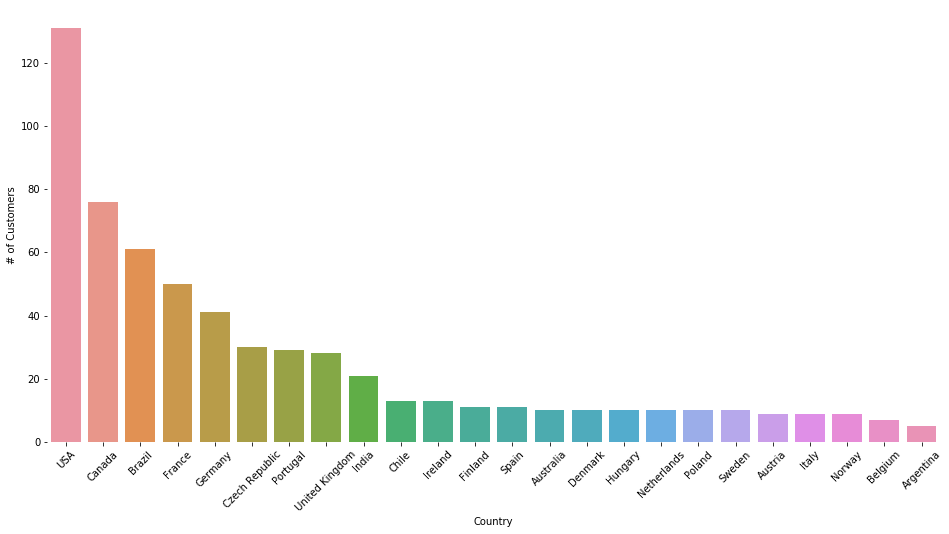

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.barplot('country', 'customers', data=custdata)
ax.set_xticklabels(custdata['country'], rotation=45)
ax.set_ylabel("# of Customers")
ax.set_xlabel("Country")
sns.despine(left=True, bottom=True)
plt.show()

We can observe from the graph above that the majority of customers are actually in the following top 5 countries:

1. USA
2. Canada
3. Brazil
4. France
5. Germany

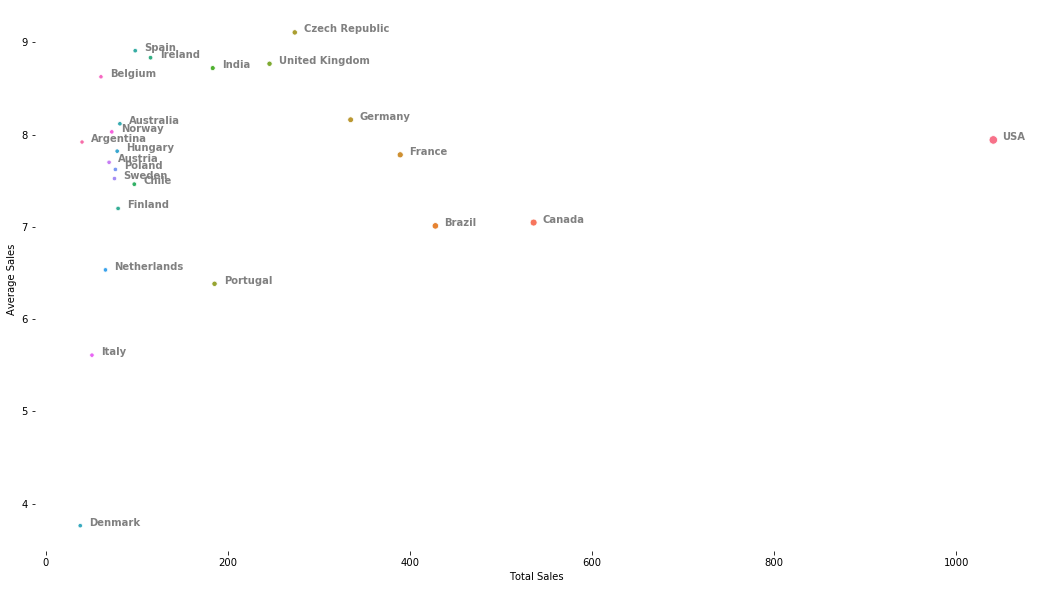

In [13]:
fig, ax = plt.subplots(figsize=(18,10))
sns.scatterplot('total', 'avg_sales', 'country', size='customers',data=custdata, legend=False)
ax.set_ylabel("Average Sales")
ax.set_xlabel("Total Sales")
sns.despine(left=True, bottom=True)
for line in range(0,custdata.shape[0]):
     ax.text(custdata.total[line]+10, custdata.avg_sales[line], 
     custdata.country[line], horizontalalignment='left', 
     size='medium', color='gray', weight='semibold')
plt.show()

Looking at the scatter plot we can quickly identify some patterns. Most of our countries have an average value of sale of 6.5 and above. USA dominates with the highest total sales with Canada going second. Chezch Republic and Spain seem to have the highest average values of sales. We can recommend that countries like France, Germany, Brazil and Canada have a good potential for growth simply because they have a good average value per sale as well as total sales in those countries is quite high. Countries like UK, India, Spain, Ireland and Belgium seem to pay for our product quite high on average, thus those countries could be a good place to start growing as well. 

## Albums vs Individual Tracks

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:


* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

Next we will write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

* Number of invoices
* Percentage of invoices

In [14]:
query = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''


In [15]:
trackalbdata = run_query(query)
print(trackalbdata.shape)
trackalbdata.head()

(2, 3)


,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


## Additional Business Questions

For additional more practice, you can look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get you started:

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?